# Bibliotecas utilizadas

In [5]:
from pathlib import Path
from typing import List, Text
from enum import Enum, auto
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator

# Arquivos CSV disponíveis na pasta

-1.2003646677471605e-08
0.00026608873493242513
mínimo período de amostragem: 3.573
máximo período de amostragem: 16.155
porcentagem dos períodos de amostragem p tal que         p <  8.0:  0.06% (   25/39489)
porcentagem dos períodos de amostragem p tal que  8.0 <= p <  9.9:  2.12% (  839/39489)
porcentagem dos períodos de amostragem p tal que  9.9 <= p < 10.1: 95.71% (37794/39489)
porcentagem dos períodos de amostragem p tal que 10.1 <= p < 12.0:  2.07% (  819/39489)
porcentagem dos períodos de amostragem p tal que 12.0 <= p       :  0.03% (   12/39489)


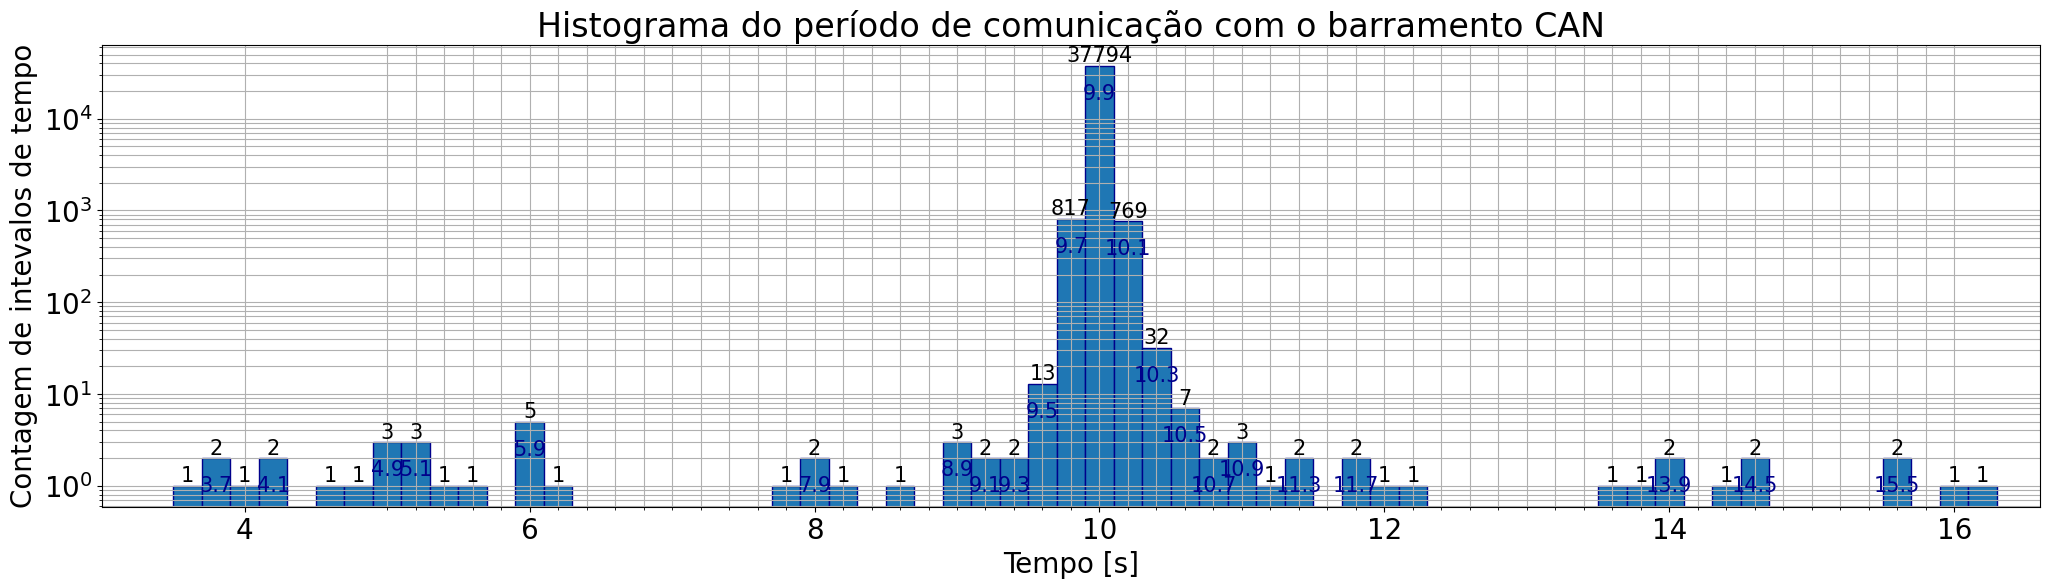

In [6]:

plt.rcParams.update({'font.size':20})
current_dir = Path.cwd()

tempo = []

for csv_file in current_dir.iterdir():
    if csv_file.is_file:
        if csv_file.suffix == ".csv":
            #print(csv_file.name)
            try:
                df = pd.read_csv(csv_file)
            except:
                df = pd.read_csv(csv_file, skiprows=12)
            tempo.append({})
            tempo[-1]['time_us'] = df['time_us'].to_numpy()
            tempo[-1]['time_us'] = df['time_us'].to_numpy()
dt = []
for tt in tempo:
    dt += list(np.diff(tt['time_us']))
dt = np.asarray(dt)/1e3

#ax = plt.plot(dt[-1][0:10])

fig, ax6 = plt.subplots(figsize=(25, 6))

delta_time_s=dt

counts, edges, bars = ax6.hist(delta_time_s, edgecolor='darkblue', bins=(np.arange(1.9,17.5,.2)))
print(np.average(np.diff(delta_time_s/1e3)))
print(np.std(np.diff(delta_time_s/1e3)))
ax6.bar_label(bars, labels=[np.round(b.xy[0],3) for b in bars], label_type='center', fontsize=15, color='darkblue')
ax6.bar_label(bars, fontsize=15)
ax6.set_title('Histograma do período de comunicação com o barramento CAN')
ax6.set_ylabel('Contagem de intevalos de tempo')
ax6.set_xlabel('Tempo [s]')
ax6.set_yscale('log')
ax6.xaxis.set_minor_locator(FixedLocator(np.arange(5,16,.2)))
ax6.grid(True, which='both')
#ax6.set_xticks(np.arange(5,16,.5))
e=[*list(counts>0),False]
ax6.set_xlim([np.min(edges[e])-0.5,np.max(edges[e])+0.5])
plt.draw()
print(f"mínimo período de amostragem: {np.min(delta_time_s)}")
print(f"máximo período de amostragem: {np.max(delta_time_s)}")

acc = 0
upper = 8
for i in range(len(edges)):
    if edges[i] < upper:
        if i < len(counts):
            acc += counts[i]

print(f'porcentagem dos períodos de amostragem p tal que {" ":7} p < {upper:4.1f}: {round((acc/np.sum(counts))*100,2):5.2f}% ({int(acc):5}/{int(np.sum(counts))})')

acc = 0
lower = 8
upper = 9.9
for i in range(len(edges)):
    if edges[i] >= lower and edges[i] < upper:
        if i < len(counts):
            acc += counts[i]

print(f'porcentagem dos períodos de amostragem p tal que {lower:4.1f} <= p < {upper:4.1f}: {round((acc/np.sum(counts))*100,2):5.2f}% ({int(acc):5}/{int(np.sum(counts))})')

acc = 0
lower = 9.9
upper = 10.1
for i in range(len(edges)):
    if edges[i] >= lower and edges[i] < upper:
        if i < len(counts):
            acc += counts[i]

print(f'porcentagem dos períodos de amostragem p tal que {lower:4.1f} <= p < {upper:4.1f}: {round((acc/np.sum(counts))*100,2):5.2f}% ({int(acc):5}/{int(np.sum(counts))})')

acc = 0
lower = 10.1
upper = 12
for i in range(len(edges)):
    if edges[i] >= lower and edges[i] < upper:
        if i < len(counts):
            acc += counts[i]

print(f'porcentagem dos períodos de amostragem p tal que {lower:4.1f} <= p < {upper:4.1f}: {round((acc/np.sum(counts))*100,2):5.2f}% ({int(acc):5}/{int(np.sum(counts))})')

acc = 0
lower = 12
for i in range(len(edges)):
    if edges[i] >= lower:
        if i < len(counts):
            acc += counts[i]

print(f'porcentagem dos períodos de amostragem p tal que {lower:4.1f} <= p {" ":6}: {round((acc/np.sum(counts))*100,2):5.2f}% ({int(acc):5}/{int(np.sum(counts))})')

# Utilitários para geração dos gráficos

In [7]:
class ReferenceType(Enum):
    ConstantNull = auto()
    SineWave = auto()

class ControlType(Enum):
    DLQR = auto()
    EventDLQR = auto()

def get_refresh_rate(data:Text) -> float:
    return float(re.findall("refresh_rate = ([0-9]*\.[0-9]*e[+-][0-9]*)", data)[0])

def get_metrica_comparacao(reference_signal:np.ndarray, signal:np.ndarray, time:np.ndarray) -> float:
    return np.trapz(np.square(reference_signal-signal), time)/np.max(time)

def plotManoplaExperiment(file:Path, title:Text, control_type:ControlType, reference_type:ReferenceType, **kwargs):
    
    skip_lines = 12
    non_csv = ""

    with open(file, 'r') as f:
        for line_number in range(skip_lines+1):
            non_csv = non_csv + f.readline()
    print(non_csv)

    refresh_rate=get_refresh_rate(non_csv)

    df = pd.read_csv(file, skiprows=skip_lines)
    df['time_us'] = df['time_us'] - df['time_us'][0]
    df['time_s'] = df['time_us']/1e6
    df['angle_o'] = df['pulse_qc']*360/(2000*3.5)
    df['angle_tracked_reference_o'] = df['tracked_reference']*360/(2000*3.5)

    time = df['time_s'].to_numpy()
    
    angle = {'numpy': df['angle_o'].to_numpy(),
             'line':'-',
             'color': 'tab:blue',
             'linewidth':2,
             'zorder':50,
             'legend': 'Posição angular',
             }
    
    angle_tracked_reference = {'numpy': df['angle_tracked_reference_o'].to_numpy(),
                              'line':'-',
                              'color': 'tab:orange',
                              'linewidth':2,
                              'zorder':25,
                              'legend': 'Referência de posição angular',
                              }
    
    event_max_error = {'numpy': df['event_max_error'].to_numpy(),
                      'line':'-o',
                      'color': 'tomato',
                      'markersize':2,
                      'zorder': 20,
                      'legend': 'Máx erro',
                      }
    
    event_error = {'numpy': df['event_error'].to_numpy(),
                   'line':'-o',
                   'color': 'gold',
                   'markersize':2,
                   'zorder': 15,
                   'legend': 'Erro',
                   }
    
    setpoint_current = {'numpy': df['setpoint_current_mA'].to_numpy(),
                      'line':'-o',
                      'color': 'green',
                      'markersize':2,
                      'zorder':10,
                      'legend': 'Corrente de referência para a EPOS',
                      }
    actual_current = {'numpy': df['actual_current_mA'].to_numpy(),
                     'line':'-o',
                     'color': 'magenta',
                     'markersize':2,
                     'zorder':5,
                     'legend': 'Corrente de saída da EPOS',
                     }
    
    metrica_comparacao=get_metrica_comparacao(angle_tracked_reference['numpy'], angle['numpy'], time)
        
    plt.rcdefaults()
    plt.rc('font', size=20)
    leg = []
    leg2 = []
    fig, ax = plt.subplots(figsize=(30,8))
    ax.plot(time, angle['numpy'], angle['line'], color=angle['color'], linewidth=angle['linewidth'], zorder=angle['zorder'])
    leg.append(angle['legend'])

    if reference_type == ReferenceType.SineWave:
        ax.plot(time, angle_tracked_reference['numpy'], angle_tracked_reference['line'], color=angle_tracked_reference['color'], linewidth=angle_tracked_reference['linewidth'], zorder=angle_tracked_reference['zorder'])
        leg.append(angle_tracked_reference['legend'])

    if control_type == ControlType.EventDLQR:
        ax.plot(time, event_error['numpy'], event_error['line'], color=event_error['color'], markersize=event_error['markersize'], zorder=event_error['zorder'])
        leg.append(event_error['legend'])
        ax.plot(time, event_max_error['numpy'], event_max_error['line'], color=event_max_error['color'], markersize=event_max_error['markersize'], zorder=event_max_error['zorder'])
        leg.append(event_max_error['legend'])

    ax2 = ax.twinx()
    ax2.plot(time, setpoint_current['numpy'], setpoint_current['line'], color=setpoint_current['color'], markersize=setpoint_current['markersize'], zorder=setpoint_current['zorder'])
    leg2.append(setpoint_current['legend'])
    ax2.plot(time, actual_current['numpy'], actual_current['line'], color=actual_current['color'], markersize=actual_current['markersize'], zorder=actual_current['zorder'])
    leg2.append(actual_current['legend'])
    

    ax.legend(leg, loc='upper center')
    ax.set_ylabel('Ângulo [°]')
    ax.set_xlabel('Tempo [s]')
    ax2.legend(leg2)
    ax2.set_ylabel('Corrente [mA]')
    ax.grid()

    if control_type == ControlType.EventDLQR:
        xticks = []
        df['time_s'] >= 13.5
        np.all
        for t, e, me in zip(df['time_s'], df['event_error'], df['event_max_error']):
            if e > me:
                xticks.append(t)
        ax.xaxis.set_minor_locator(FixedLocator(xticks))

    #ax.xaxis.set_major_locator(FixedLocator(np.arange(0,np.max(xticks), 1)))
    #ax.set_xticks([*xticks, *np.arange(0,np.max(xticks), 5)], labels=['' if not l%5 == 0 else l for l in np.sort([*xticks, *np.arange(0,np.max(xticks), 5)])])
    

    ax.grid(which = "major", linewidth=2, axis = 'x')
    ax.grid(which = "minor", alpha = 0.5)
    ax.xaxis.set_major_locator(FixedLocator(np.arange(0,np.max(time), .5)))
    ax.grid(True, which='minor', color='tomato')

    if 'xlim' in kwargs:
        plt.xlim(kwargs['xlim'])

    if 'xlabelrotation' in kwargs:
        ax.tick_params(axis='x', labelrotation=kwargs['xlabelrotation'])

    print("max time step:", np.max(np.diff(time)))
    print("min time step:", np.min(np.diff(time)))
    print("avg time step:", np.average(np.diff(time)))
    print("max max erro:", np.max(event_max_error['numpy']))

    plt.title(title.format(np.round(refresh_rate,2), np.round(metrica_comparacao,2)))
    plt.show()

    plt.rcdefaults()

# DR6

[Configuration]
controller_type = dlqr
reference_type = constant-zero
A = [ [ 9.9860906100e-01  ,  -1.1312366800e-04 ] , [ 9.9860906100e-01  ,  -1.1312366800e-04 ] ] 
B = [ [ 8.6104000000e-03] , [8.0799000000e-04 ]]
K = [ [ -8.9917800000e+01  ,  -1.1554100000e+03 ]]
event_a = 0.0000000000e+00
event_b = 0.0000000000e+00
event_sigma = 0.0000000000e+00
refresh_rate = 1.0000000000e+02

[Table]
time_us,pulse_qc,setpoint_current_mA,actual_current_mA,epos_velocity_unfiltered_rpm,calculated_velocity_rad/s,tracked_reference,event_max_error,event_error

max time step: 0.01030600000000037
min time step: 0.009781999999999957
avg time step: 0.01000029179331307
max max erro: 0.0


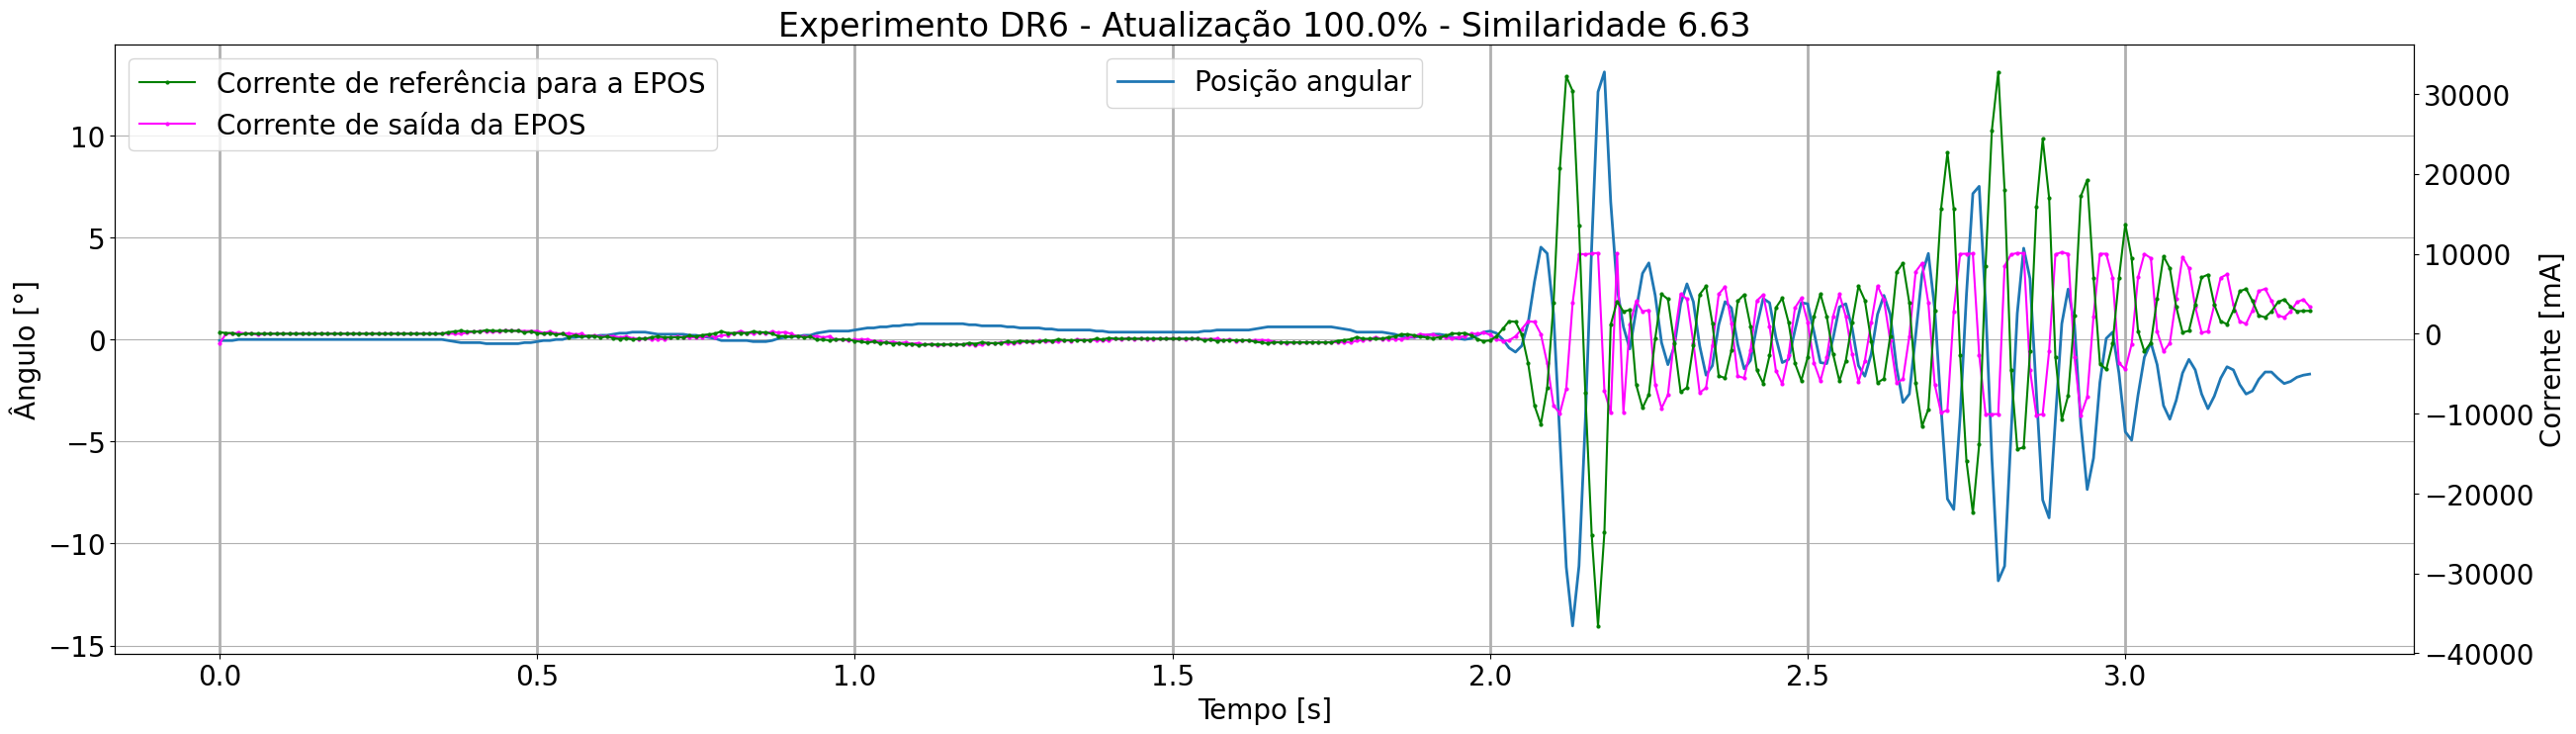

time_us  pulse_qc  setpoint_current_mA  actual_current_mA  \
0     418070        -1           191.097656              -1238   
1     428168        -1            89.917801                -13   
2     438207        -1            89.917801                 19   
3     448164         0          -104.157242                116   
4     458211         0             0.000000                 51   
..       ...       ...                  ...                ...   
325  3668164       -42          4297.281738               2066   
326  3678204       -40          3390.119629               2775   
327  3688165       -36          2820.578369               3951   
328  3698341       -34          2853.374268               4289   
329  3708166       -33          2861.730957               3403   

     epos_velocity_unfiltered_rpm  calculated_velocity_rad/s  \
0                               0                  -0.087571   
1                               0                   0.000000   
2                               0                   0.000000   
3                               0                   0.090147   
4                               0                   0.000000   
..                            ...                        ...   
325                           -30                  -0.450692   
326                            30                   0.178804   
327                             0                   0.360445   
328                             0                   0.176414   
329                             0                   0.091358   

     tracked_reference  event_max_error  event_error  
0                  0.0              0.0          0.0  
1                  0.0              0.0          0.0  
2                  0.0              0.0          0.0  
3                  0.0              0.0          0.0  
4                  0.0              0.0          0.0  
..                 ...              ...          ...  
325                0.0              0.0          0.0  
326                0.0              0.0          0.0  
327                0.0              0.0          0.0  
328                0.0              0.0          0.0  
329                0.0              0.0          0.0  

[330 rows x 9 columns]

In [8]:
file = Path('log_2024-02-22_03-16-38_dlqr_DR6.csv')

plotManoplaExperiment(file, "Experimento DR6 - Atualização {}% - Similaridade {}", ControlType.DLQR, ReferenceType.ConstantNull)

df = pd.read_csv(file, skiprows = 12)
df

# DC6

[Configuration]
controller_type = dlqr
reference_type = sine-wave
A = [ [ 9.9860906100e-01  ,  -1.1312366800e-04 ] , [ 9.9860906100e-01  ,  -1.1312366800e-04 ] ] 
B = [ [ 8.6104000000e-03] , [8.0799000000e-04 ]]
K = [ [ -8.9917800000e+01  ,  -1.1554100000e+03 ]]
event_a = 0.0000000000e+00
event_b = 0.0000000000e+00
event_sigma = 0.0000000000e+00
refresh_rate = 1.0000000000e+02

[Table]
time_us,pulse_qc,setpoint_current_mA,actual_current_mA,epos_velocity_unfiltered_rpm,calculated_velocity_rad/s,tracked_reference,event_max_error,event_error

max time step: 0.01051000000000002
min time step: 0.009489000000000303
avg time step: 0.010000414674361087
max max erro: 0.0


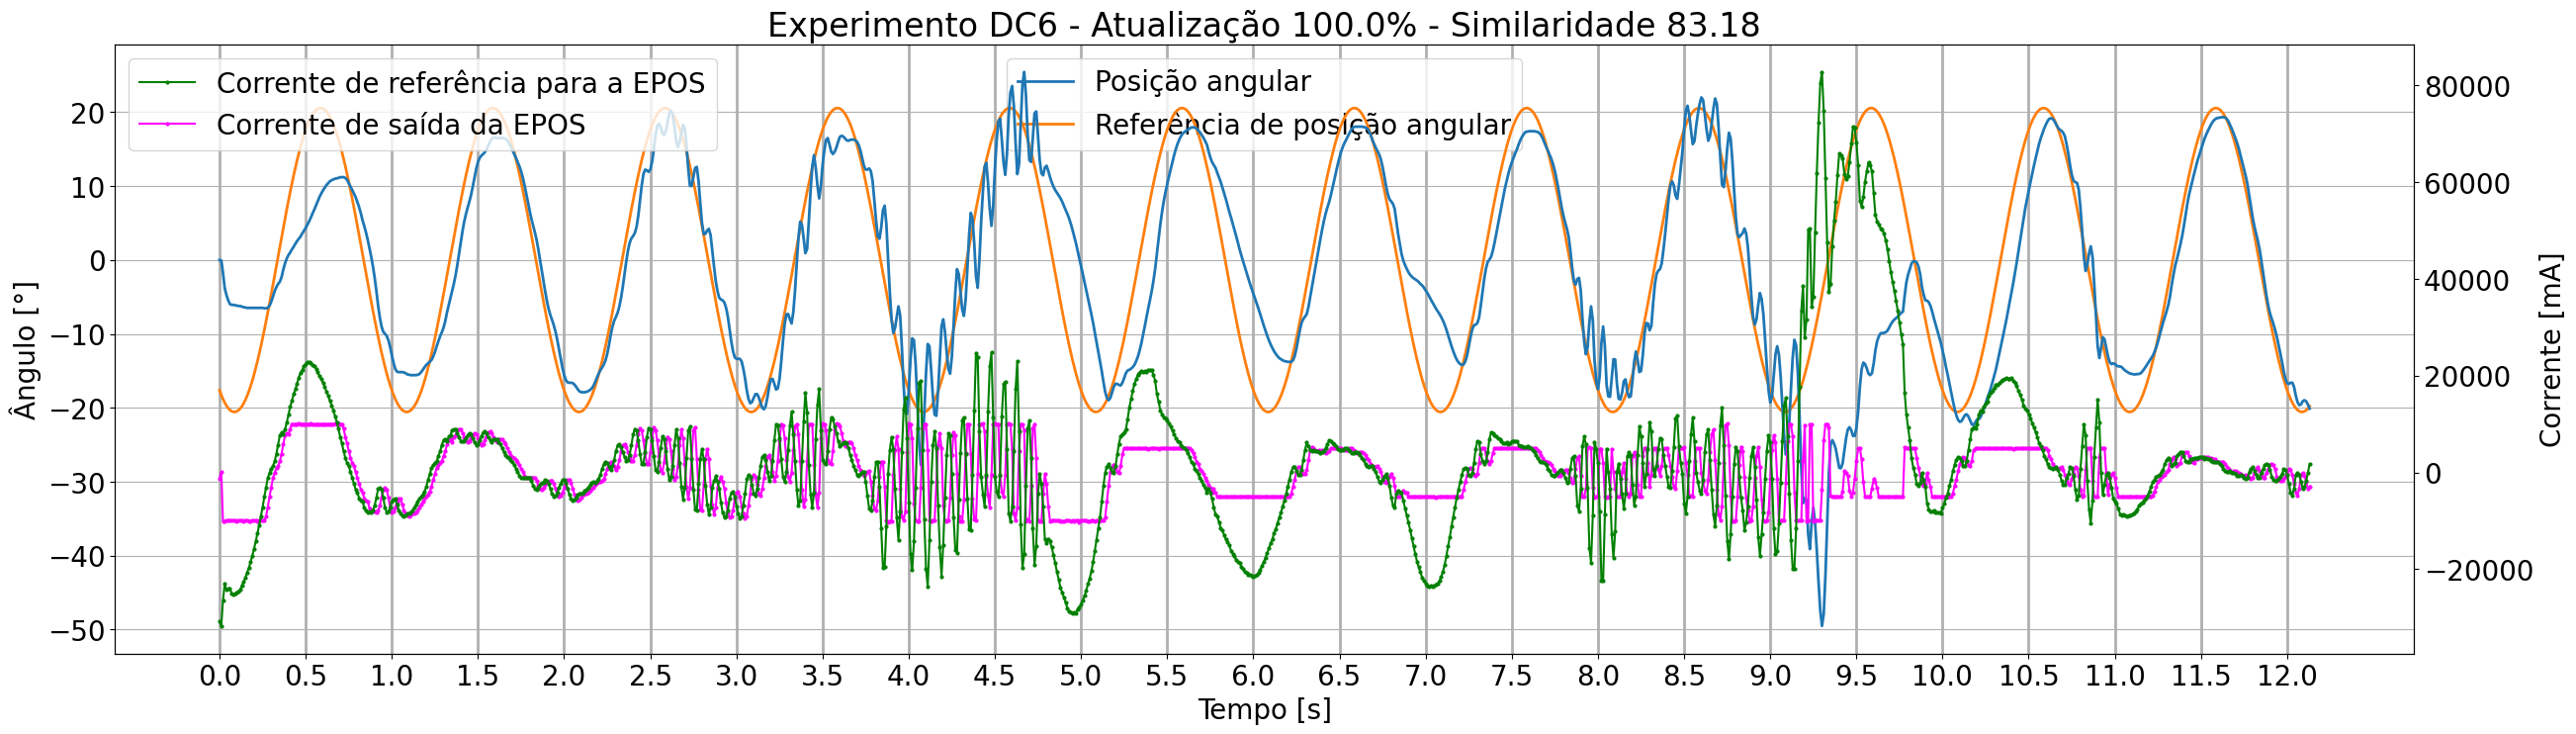

time_us  pulse_qc  setpoint_current_mA  actual_current_mA  \
0       413596         0        -30795.697266              -1263   
1       423981        -1        -31751.955078                 26   
2       433938       -34        -26418.546875             -10126   
3       443982       -74        -22978.033203             -10077   
4       453941       -92        -24324.574219              -9965   
...        ...       ...                  ...                ...   
1209  12503980      -372         -3371.154785               -103   
1210  12513936      -369         -2962.159180               -635   
1211  12524099      -372         -1800.029053              -1972   
1212  12534052      -380          -144.663254              -3358   
1213  12544099      -391          1698.070435              -2939   

      epos_velocity_unfiltered_rpm  calculated_velocity_rad/s  \
0                                0                   0.000000   
1                              -30                  -0.086432   
2                             -180                  -2.974865   
3                              -90                  -3.574663   
4                              -30                  -1.622328   
...                            ...                        ...   
1209                            30                   0.748394   
1210                             0                   0.270469   
1211                           -30                  -0.264960   
1212                           -30                  -0.721475   
1213                           -30                  -0.982735   

      tracked_reference  event_max_error  event_error  
0           -342.487213              0.0   342.487213  
1           -355.232636              0.0   354.232636  
2           -366.033661              0.0   332.033661  
3           -375.477936              0.0   301.477936  
4           -383.366425              0.0   291.366425  
...                 ...              ...          ...  
1209        -399.874939              0.0    27.874935  
1210        -398.467529              0.0    29.467543  
1211        -395.423248              0.0    23.423243  
1212        -390.879517              0.0    10.879521  
1213        -384.743073              0.0    -6.256920  

[1214 rows x 9 columns]

In [9]:
file = Path('log_2024-02-22_03-35-00_dlqr_DC6.csv')

plotManoplaExperiment(file, "Experimento DC6 - Atualização {}% - Similaridade {}", ControlType.DLQR, ReferenceType.SineWave)

df = pd.read_csv(file, skiprows = 12)
df

# EDR24

[Configuration]
controller_type = dlqr-event
reference_type = constant-zero
A = [ [ 9.9860906100e-01  ,  -1.1312366800e-04 ] , [ 9.9860906100e-01  ,  -1.1312366800e-04 ] ] 
B = [ [ 8.6104000000e-03] , [8.0799000000e-04 ]]
K = [ [ -1.9097800000e+00  ,  -1.9449100000e+02 ]]
event_a = 1.6000000000e+01
event_b = 1.0000000000e-03
event_sigma = 1.0000000000e-02
refresh_rate = 1.7794353485e+01

[Table]
time_us,pulse_qc,setpoint_current_mA,actual_current_mA,epos_velocity_unfiltered_rpm,calculated_velocity_rad/s,tracked_reference,event_max_error,event_error

max time step: 0.010363
min time step: 0.004911
avg time step: 0.009997429815016322
max max erro: 29.65133667


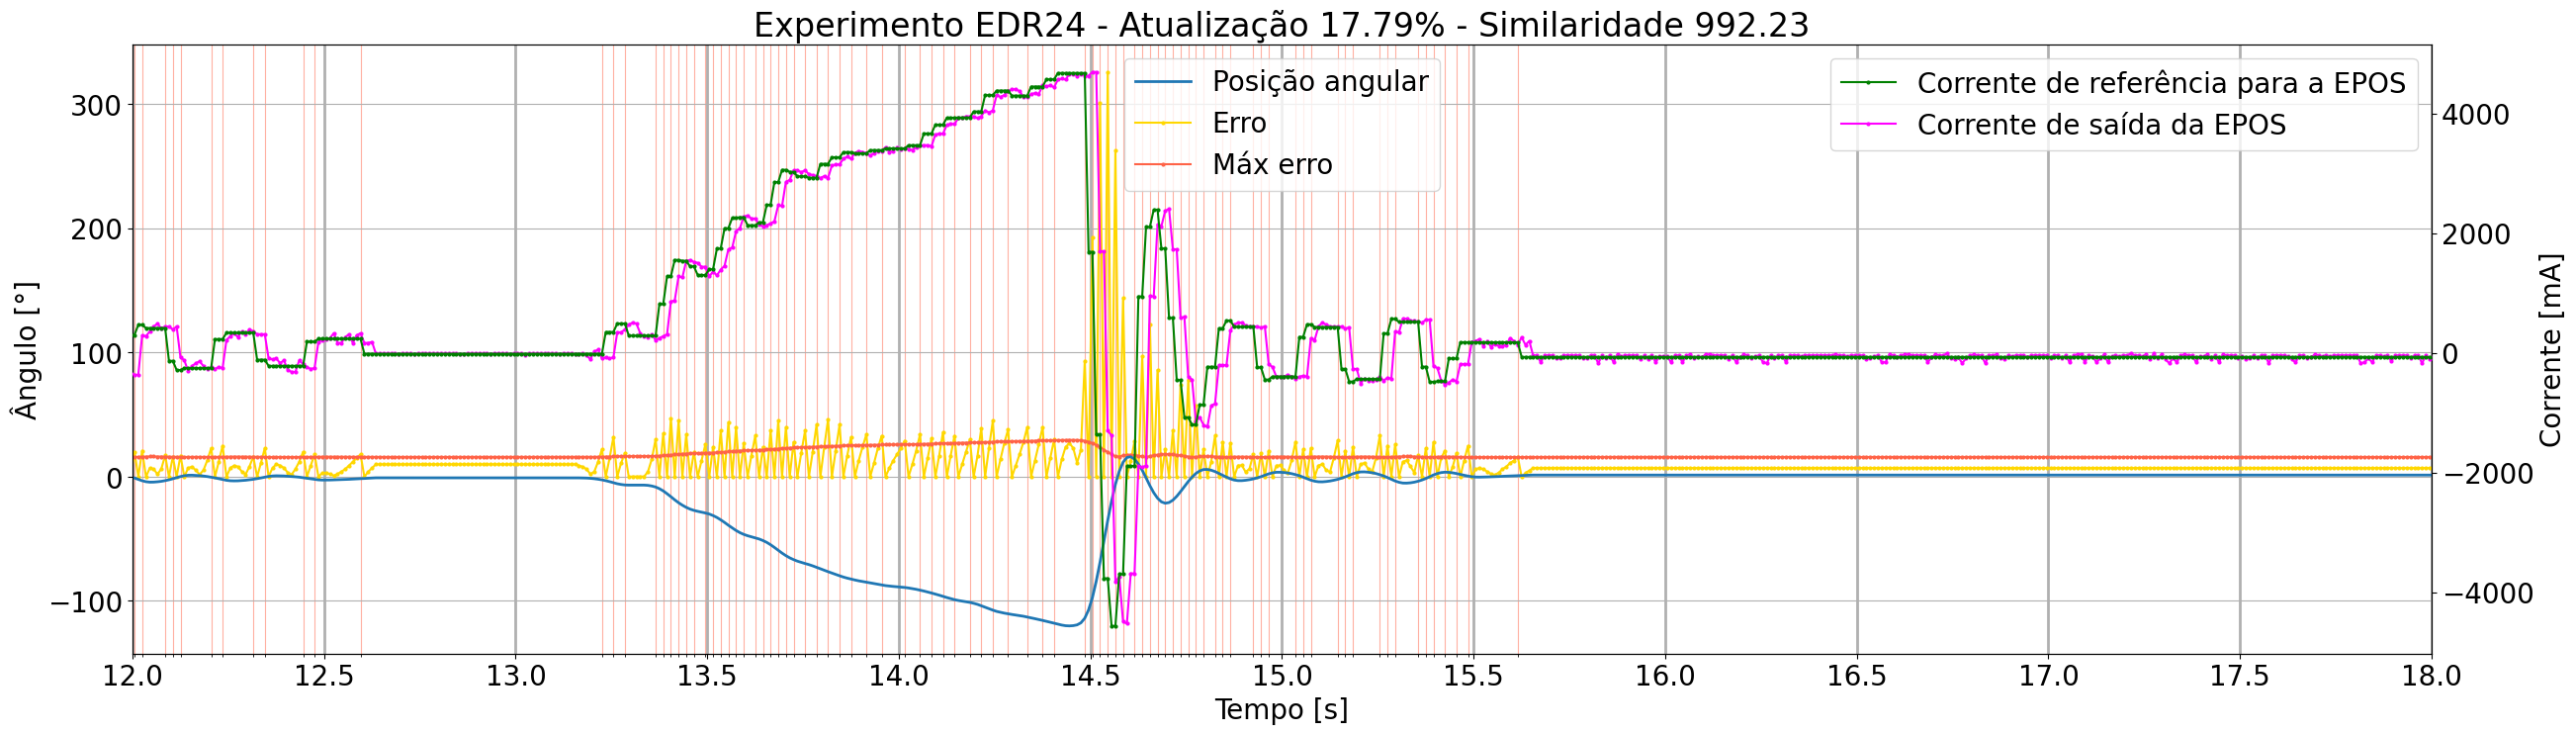

[Configuration]
controller_type = dlqr-event
reference_type = constant-zero
A = [ [ 9.9860906100e-01  ,  -1.1312366800e-04 ] , [ 9.9860906100e-01  ,  -1.1312366800e-04 ] ] 
B = [ [ 8.6104000000e-03] , [8.0799000000e-04 ]]
K = [ [ -1.9097800000e+00  ,  -1.9449100000e+02 ]]
event_a = 1.6000000000e+01
event_b = 1.0000000000e-03
event_sigma = 1.0000000000e-02
refresh_rate = 0.0000000000e+00

[Table]
time_us,pulse_qc,setpoint_current_mA,actual_current_mA,epos_velocity_unfiltered_rpm,calculated_velocity_rad/s,tracked_reference,event_max_error,event_error

max time step: 0.01361699999999999
min time step: 0.003898
avg time step: 0.009996395652173914
max max erro: 16.0116539


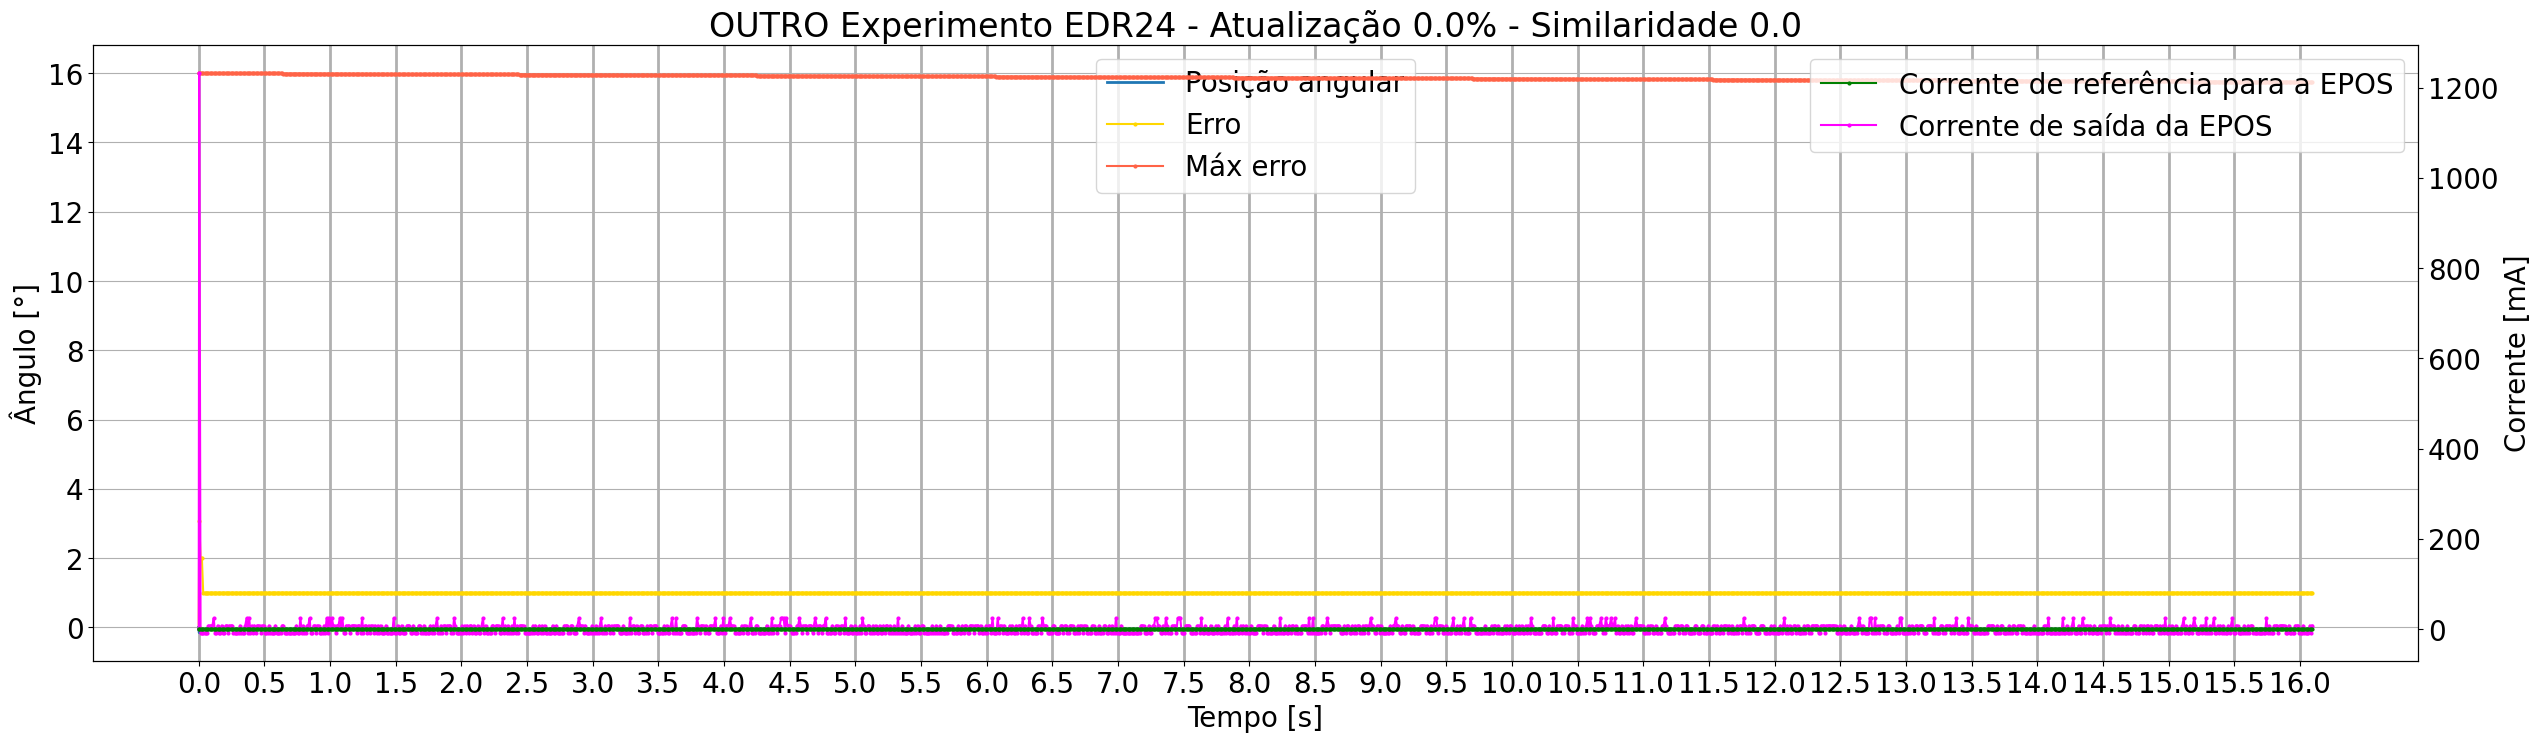

time_us  pulse_qc  setpoint_current_mA  actual_current_mA  \
0       411494         0                  0.0                  0   
1       415392        -3                  0.0               1233   
2       425690        -2                  0.0                 -8   
3       435755        -2                  0.0                 -8   
4       445691        -1                  0.0                 -8   
...        ...       ...                  ...                ...   
1606  16465690        -1                  0.0                 -8   
1607  16475737        -1                  0.0                 -8   
1608  16485692        -1                  0.0                  8   
1609  16495732        -1                  0.0                 -8   
1610  16505691        -1                  0.0                  8   

      epos_velocity_unfiltered_rpm  calculated_velocity_rad/s  \
0                                0                   0.000000   
1                                0                  -0.690814   
2                                0                   0.087162   
3                                0                   0.000000   
4                               30                   0.090338   
...                            ...                        ...   
1606                             0                   0.000000   
1607                             0                   0.000000   
1608                             0                   0.000000   
1609                             0                   0.000000   
1610                             0                   0.000000   

      tracked_reference  event_max_error  event_error  
0                   0.0        15.993414     0.000000  
1                   0.0        16.011654     3.078510  
2                   0.0        16.005089     2.001899  
3                   0.0        16.004915     2.000000  
4                   0.0        15.998837     1.004072  
...                 ...              ...          ...  
1606                0.0        15.744521     1.000000  
1607                0.0        15.744363     1.000000  
1608                0.0        15.744206     1.000000  
1609                0.0        15.744048     1.000000  
1610                0.0        15.743892     1.000000  

[1611 rows x 9 columns]

In [18]:
file = Path('log_2024-02-22_03-41-37_dlqr-event_EDR24.csv')

plotManoplaExperiment(file,
                      "Experimento EDR24 - Atualização {}% - Similaridade {}",
                      ControlType.EventDLQR,
                      ReferenceType.ConstantNull,
                      xlim=([12,18]))

df = pd.read_csv(file, skiprows = 12)

df





file = Path('log_2024-02-22_14-57-04_dlqr-event_EDR24.csv')

plotManoplaExperiment(file,
                      "OUTRO Experimento EDR24 - Atualização {}% - Similaridade {}",
                      ControlType.EventDLQR,
                      ReferenceType.ConstantNull)

df = pd.read_csv(file, skiprows = 12)

df

# EDR83

[Configuration]
controller_type = dlqr-event
reference_type = constant-zero
A = [ [ 9.9860906100e-01  ,  -1.1312366800e-04 ] , [ 9.9860906100e-01  ,  -1.1312366800e-04 ] ] 
B = [ [ 8.6104000000e-03] , [8.0799000000e-04 ]]
K = [ [ -2.1676400000e+01  ,  -6.4405200000e+02 ]]
event_a = 1.0000000000e+01
event_b = 2.0000000000e-01
event_sigma = 1.0000000000e-02
refresh_rate = 2.3557926178e+01

[Table]
time_us,pulse_qc,setpoint_current_mA,actual_current_mA,epos_velocity_unfiltered_rpm,calculated_velocity_rad/s,tracked_reference,event_max_error,event_error

max time step: 0.010944999999999538
min time step: 0.004824
avg time step: 0.009997621661721069
max max erro: 9.0951519012


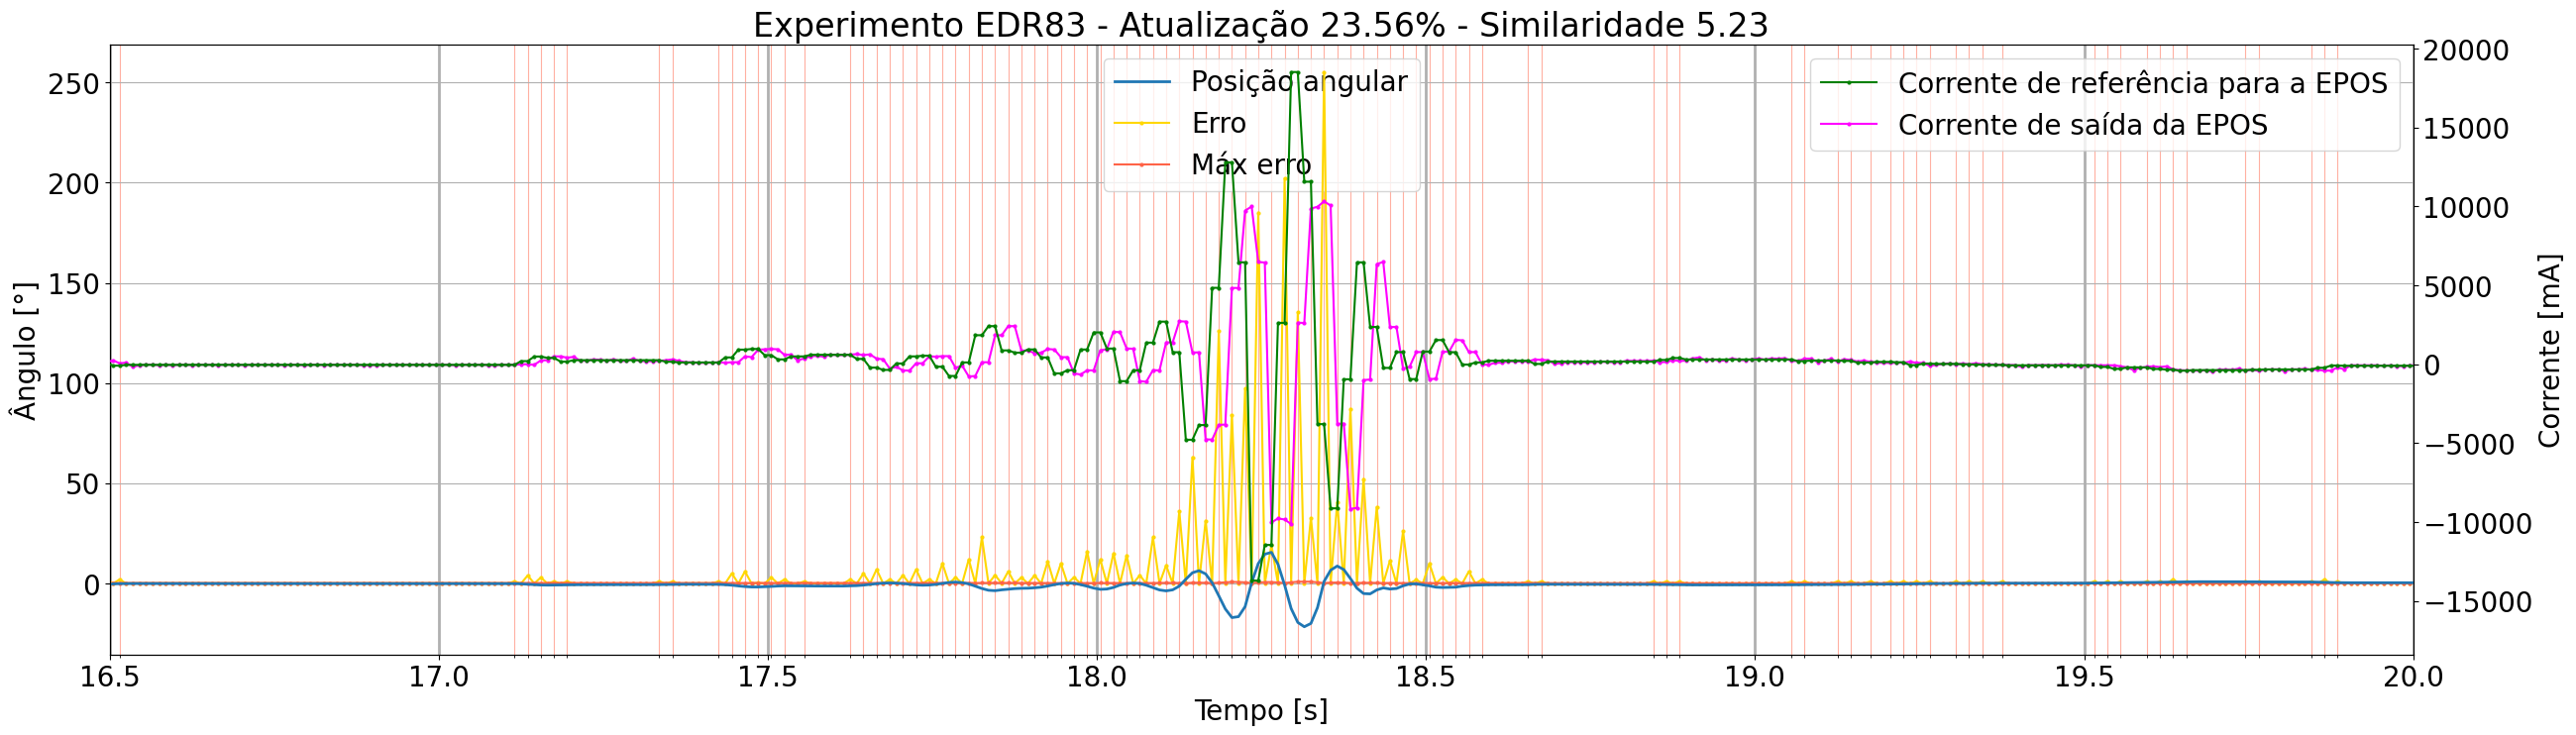

time_us  pulse_qc  setpoint_current_mA  actual_current_mA  \
0       425034         0             0.000000                  0   
1       429858         2             0.000000                  1   
2       440220         2             0.000000                  1   
3       450264         1             0.000000                  1   
4       460223         1             0.000000                  1   
...        ...       ...                  ...                ...   
2018  20600222        10          -216.764008               -289   
2019  20610264        10          -216.764008               -225   
2020  20620224        11          -216.764008               -273   
2021  20630267        11          -238.440399               -289   
2022  20640225        12          -238.440399               -160   

      epos_velocity_unfiltered_rpm  calculated_velocity_rad/s  \
0                                0                   0.000000   
1                                0                   0.372138   
2                                0                   0.000000   
3                                0                  -0.089367   
4                                0                   0.000000   
...                            ...                        ...   
2018                             0                   0.000000   
2019                             0                   0.000000   
2020                             0                   0.090120   
2021                             0                   0.000000   
2022                             0                   0.090138   

      tracked_reference  event_max_error  event_error  
0                   0.0         9.095152     0.000000  
1                   0.0         9.089017     2.034327  
2                   0.0         9.067972     2.000000  
3                   0.0         9.045892     1.003985  
4                   0.0         9.025809     1.000000  
...                 ...              ...          ...  
2018                0.0         0.118783     0.000000  
2019                0.0         0.118558     0.000000  
2020                0.0         0.120129     1.004053  
2021                0.0         0.119904     0.000000  
2022                0.0         0.121476     1.004054  

[2023 rows x 9 columns]

In [11]:
file = Path('log_2024-02-23_00-16-23_dlqr-event_EDR83.csv')

plotManoplaExperiment(file,
                      "Experimento EDR83 - Atualização {}% - Similaridade {}",
                      ControlType.EventDLQR,
                      ReferenceType.ConstantNull,
                      xlim=[16.5, 20])

df = pd.read_csv(file, skiprows = 12)
df

# EDC56

[Configuration]
controller_type = dlqr-event
reference_type = sine-wave
A = [ [ 9.9860906100e-01  ,  -1.1312366800e-04 ] , [ 9.9860906100e-01  ,  -1.1312366800e-04 ] ] 
B = [ [ 8.6104000000e-03] , [8.0799000000e-04 ]]
K = [ [ -2.7008000000e+00  ,  -2.3377000000e+02 ]]
event_a = 3.0000000000e+01
event_b = 1.0000000000e-03
event_sigma = 1.0000000000e-02
refresh_rate = 3.6585365295e+01

[Table]
time_us,pulse_qc,setpoint_current_mA,actual_current_mA,epos_velocity_unfiltered_rpm,calculated_velocity_rad/s,tracked_reference,event_max_error,event_error

max time step: 0.011396000000001294
min time step: 0.008943999999999619
avg time step: 0.01000091156462585
max max erro: 34.141452789


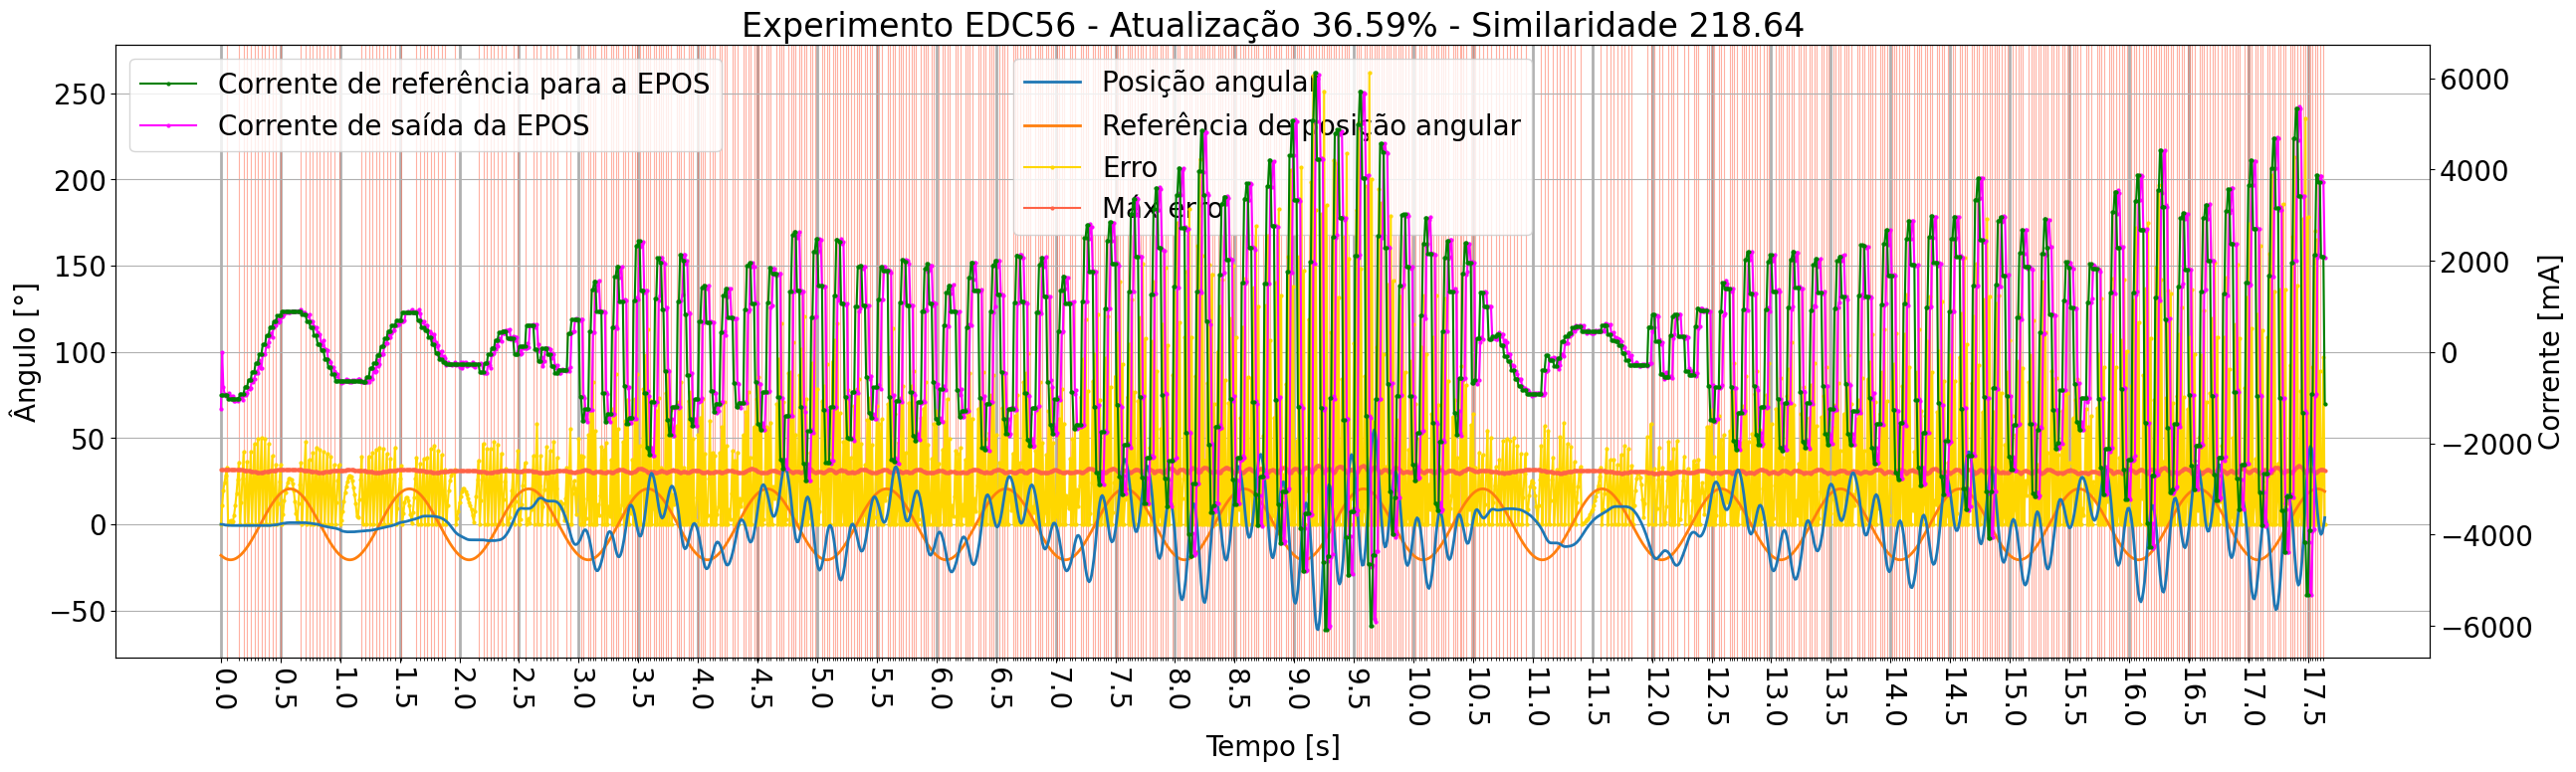

time_us  pulse_qc  setpoint_current_mA  actual_current_mA  \
0       419143         0          -943.875488              -1243   
1       429352        -1          -943.875488                 -2   
2       439311        -2          -943.875488               -759   
3       449469        -6          -943.875488               -920   
4       459312        -9          -943.875488               -969   
...        ...       ...                  ...                ...   
1760  18019312       -80          3722.822266               3849   
1761  18029357      -114          2080.115723               3865   
1762  18039311       -96          2080.115723               3720   
1763  18049355       -30          2080.115723               3736   
1764  18060751        75         -1133.328247               2060   

      epos_velocity_unfiltered_rpm  calculated_velocity_rad/s  \
0                                0                   0.000000   
1                                0                  -0.087922   
2                                0                  -0.090129   
3                                0                  -0.353455   
4                                0                  -0.273574   
...                            ...                        ...   
1760                          -210                  -8.203417   
1761                           -60                  -3.038161   
1762                           120                   1.623143   
1763                           270                   5.898194   
1764                           360                   8.270251   

      tracked_reference  event_max_error  event_error  
0           -349.479950        31.715954     0.000000  
1           -361.234406        31.768839    10.754800  
2           -371.269653        31.813229    19.789898  
3           -380.008087        31.836361    24.530680  
4           -386.999634        31.855808    28.520983  
...                 ...              ...          ...  
1760         397.058899        31.823885    88.808647  
1761         393.214508        31.972435     0.000000  
1762         387.860291        31.856598    23.814867  
1763         380.920410        31.495737    96.707863  
1764         371.211639        30.928411     0.000000  

[1765 rows x 9 columns]

In [12]:
file = Path('log_2024-02-22_04-00-01_dlqr-event_EDC56.csv')

plotManoplaExperiment(file,
                      "Experimento EDC56 - Atualização {}% - Similaridade {}",
                      ControlType.EventDLQR,
                      ReferenceType.SineWave,
                      xlabelrotation=-90)

df = pd.read_csv(file, skiprows = 12)
df

# EDC103

[Configuration]
controller_type = dlqr-event
reference_type = sine-wave
A = [ [ 9.9860906100e-01  ,  -1.1312366800e-04 ] , [ 9.9860906100e-01  ,  -1.1312366800e-04 ] ] 
B = [ [ 8.6104000000e-03] , [8.0799000000e-04 ]]
K = [ [ -5.0501400000e+01  ,  -9.2400000000e+02 ]]
event_a = 1.0000000000e+01
event_b = 2.0000000000e-01
event_sigma = 1.0000000000e-02
refresh_rate = 4.3674053192e+01

[Table]
time_us,pulse_qc,setpoint_current_mA,actual_current_mA,epos_velocity_unfiltered_rpm,calculated_velocity_rad/s,tracked_reference,event_max_error,event_error

max time step: 0.01129599999999975
min time step: 0.009765
avg time step: 0.010001097794117647
max max erro: 9.5450220108


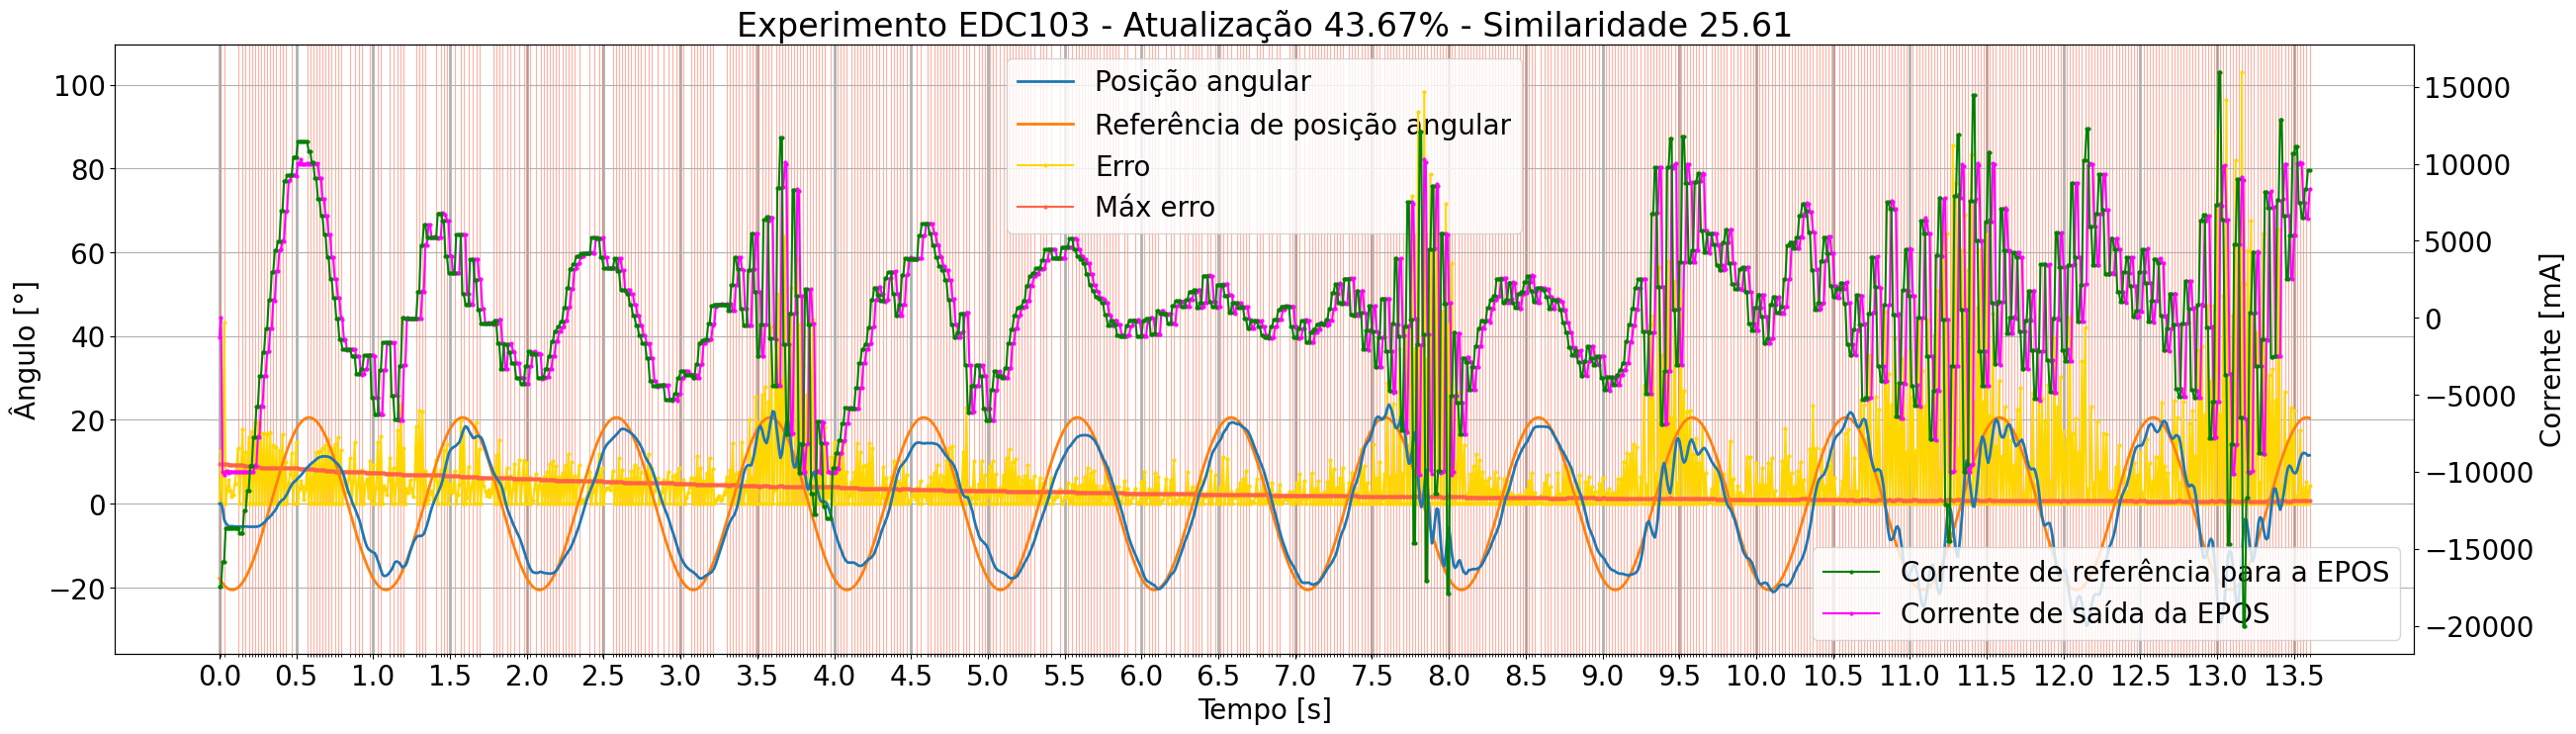

time_us  pulse_qc  setpoint_current_mA  actual_current_mA  \
0       416631         0        -17491.933594              -1246   
1       426396         1        -17491.933594                 11   
2       436869       -21        -15829.330078              -9979   
3       446833       -73        -15829.330078             -10205   
4       456868       -89        -13646.275391              -9979   
...        ...       ...                  ...                ...   
1356  13976870       236          6500.644531               7520   
1357  13986828       235          8346.877930               7488   
1358  13996869       231          8346.877930               6505   
1359  14006828       223          9586.397461               6473   
1360  14018124       225          9586.397461               8342   

      epos_velocity_unfiltered_rpm  calculated_velocity_rad/s  \
0                                0                   0.000000   
1                                0                   0.091920   
2                             -240                  -1.885530   
3                             -120                  -4.684373   
4                              -30                  -1.431147   
...                            ...                        ...   
1356                             0                   0.715361   
1357                             0                  -0.090140   
1358                             0                  -0.357571   
1359                             0                  -0.721036   
1360                             0                   0.158922   

      tracked_reference  event_max_error  event_error  
0           -346.365326         9.545022     0.000000  
1           -357.981720         9.540954    12.616721  
2           -368.942017         9.505941     0.000000  
3           -377.887817         9.432034    43.145077  
4           -385.400787         9.401144     0.000000  
...                 ...              ...          ...  
1356         395.783264         0.641739     3.751376  
1357         398.630859         0.645564     0.000000  
1358         399.922607         0.651190     5.298485  
1359         399.631958         0.659847     0.000000  
1360         397.409241         0.653463     4.313426  

[1361 rows x 9 columns]

In [13]:
file = Path('log_2024-02-23_02-05-30_dlqr-event_EDC103.csv')

plotManoplaExperiment(file, "Experimento EDC103 - Atualização {}% - Similaridade {}", ControlType.EventDLQR, ReferenceType.SineWave)

df = pd.read_csv(file, skiprows = 12)
df

# EDC103 Modificado (controlador K advindo de q = 5)

[Configuration]
controller_type = dlqr-event
reference_type = sine-wave
A = [ [ 9.9860906100e-01  ,  -1.1312366800e-04 ] , [ 9.9860906100e-01  ,  -1.1312366800e-04 ] ] 
B = [ [ 8.6104000000e-03] , [8.0799000000e-04 ]]
K = [ [ -1.9097760100e+00  ,  -1.9449064542e+02 ]]
event_a = 1.0000000000e+01
event_b = 2.0000000000e-01
event_sigma = 1.0000000000e-02
refresh_rate = 4.6531055450e+01

[Table]
time_us,pulse_qc,setpoint_current_mA,actual_current_mA,epos_velocity_unfiltered_rpm,calculated_velocity_rad/s,tracked_reference,event_max_error,event_error

max time step: 0.010405000000000001
min time step: 0.005964
avg time step: 0.00999869074824917
max max erro: 13.001206398


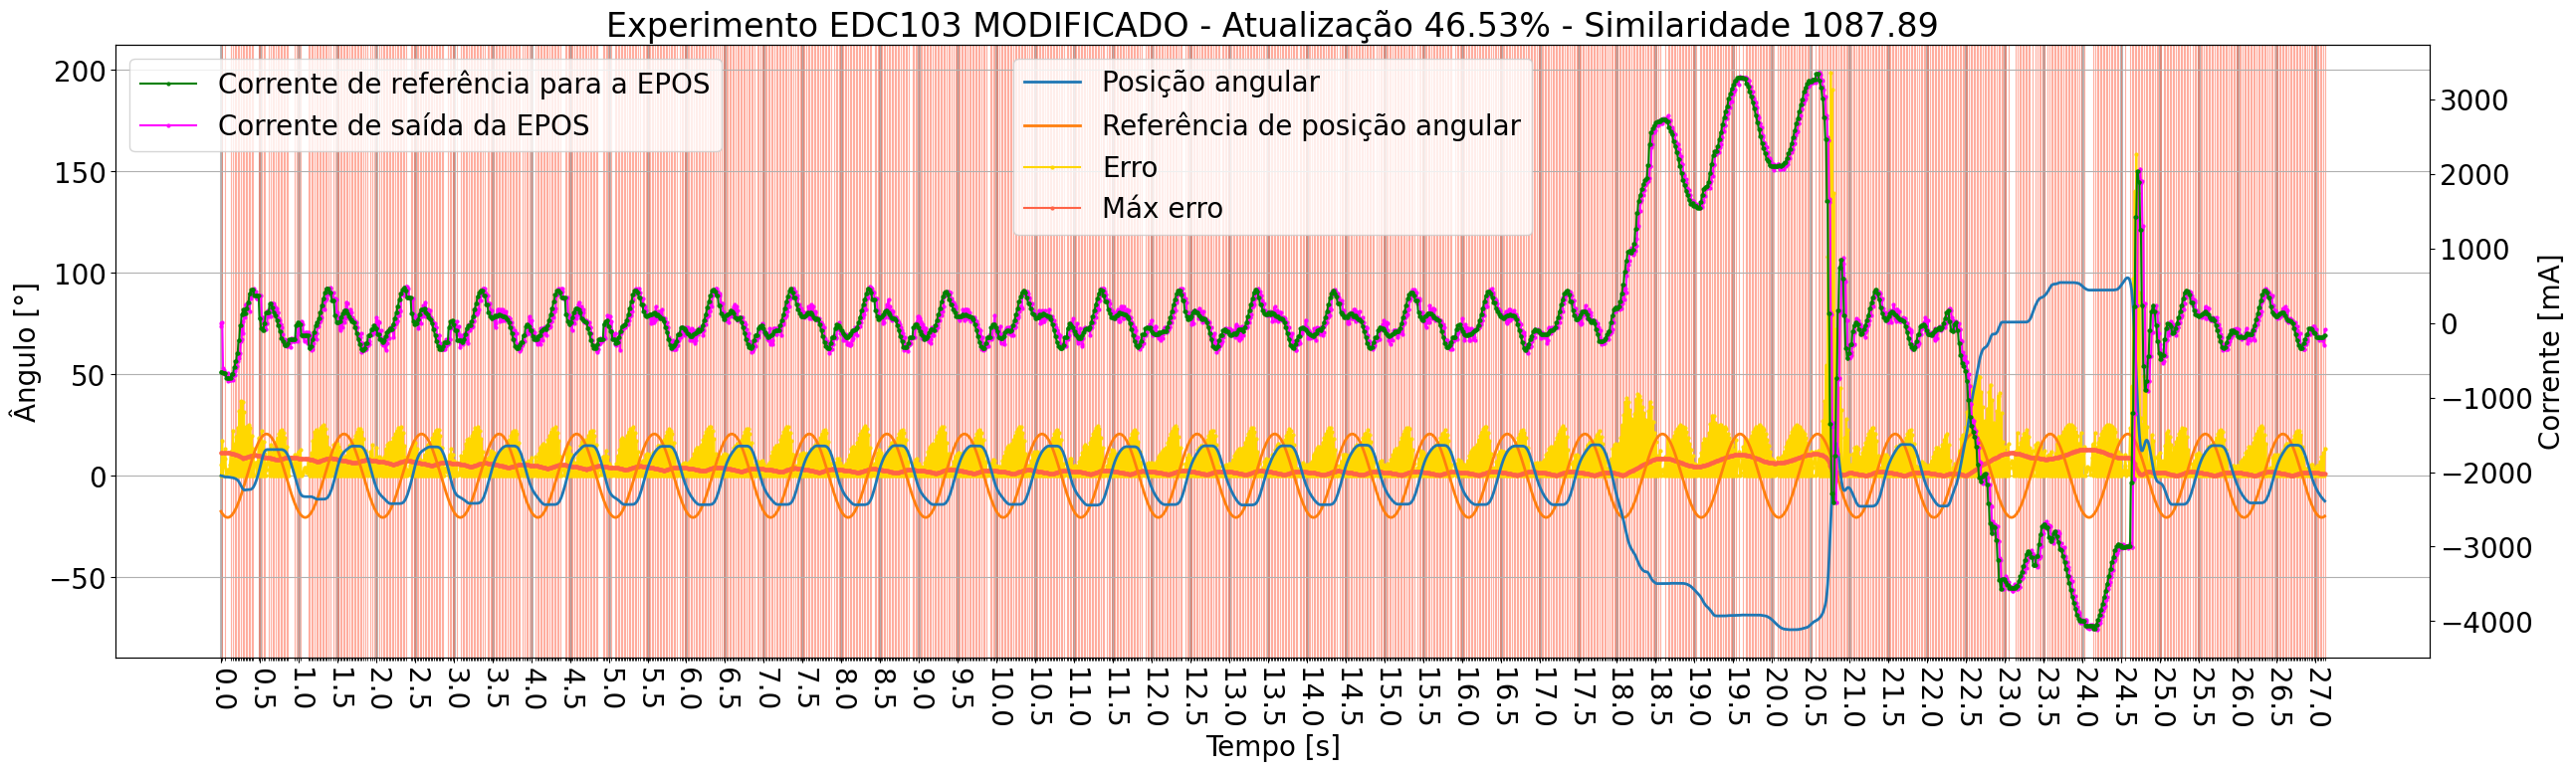

time_us  pulse_qc  setpoint_current_mA  actual_current_mA  \
0       413319         0          -653.385986                  0   
1       419283        -2          -653.385986                -39   
2       429688        -2          -653.385986                 10   
3       439645        -4          -666.932129               -603   
4       449689        -8          -666.932129               -635   
...        ...       ...                  ...                ...   
2709  27499766      -209          -191.069412               -184   
2710  27509806      -218          -189.639023               -232   
2711  27519759      -227          -189.639023               -216   
2712  27529802      -235          -162.698380               -297   
2713  27539767      -243          -162.698380                -87   

      epos_velocity_unfiltered_rpm  calculated_velocity_rad/s  \
0                                0                   0.000000   
1                               30                  -0.301005   
2                                0                   0.000000   
3                              -30                  -0.180295   
4                                0                  -0.357466   
...                            ...                        ...   
2709                           -30                  -0.901113   
2710                           -30                  -0.804618   
2711                           -30                  -0.811654   
2712                           -30                  -0.715002   
2713                             0                  -0.720602   

      tracked_reference  event_max_error  event_error  
0           -342.127045        11.152910     0.000000  
1           -349.651001        11.173623     5.532143  
2           -361.596252        11.223517    17.469213  
3           -371.581238        11.250824     0.000000  
4           -380.180359        11.257872     4.602531  
...                 ...              ...          ...  
2709        -399.999573         1.157136     9.180418  
2710        -399.240997         1.099071     0.000000  
2711        -396.921326         1.031728    11.319673  
2712        -393.007843         0.960852     0.000000  
2713        -387.578491         0.880967    13.429363  

[2714 rows x 9 columns]

In [16]:
file = Path('log_2024-02-22_04-15-39_dlqr-event_EDC103_modified.csv')

plotManoplaExperiment(file,
                      "Experimento EDC103 MODIFICADO - Atualização {}% - Similaridade {}",
                      ControlType.EventDLQR,
                      ReferenceType.SineWave,
                      xlabelrotation = -90)

df = pd.read_csv(file, skiprows = 12)
df

# EDC56 Modificado (controlador K advindo de q = 5)

[Configuration]
controller_type = dlqr-event
reference_type = sine-wave
A = [ [ 9.9860906100e-01  ,  -1.1312366800e-04 ] , [ 9.9860906100e-01  ,  -1.1312366800e-04 ] ] 
B = [ [ 8.6104000000e-03] , [8.0799000000e-04 ]]
K = [ [ -1.9097760100e+00  ,  -1.9449064542e+02 ]]
event_a = 3.0000000000e+01
event_b = 1.0000000000e-03
event_sigma = 1.0000000000e-02
refresh_rate = 2.2902025223e+01

[Table]
time_us,pulse_qc,setpoint_current_mA,actual_current_mA,epos_velocity_unfiltered_rpm,calculated_velocity_rad/s,tracked_reference,event_max_error,event_error

max time step: 0.010678999999999661
min time step: 0.004529
avg time step: 0.009998147899159664
max max erro: 42.66734314


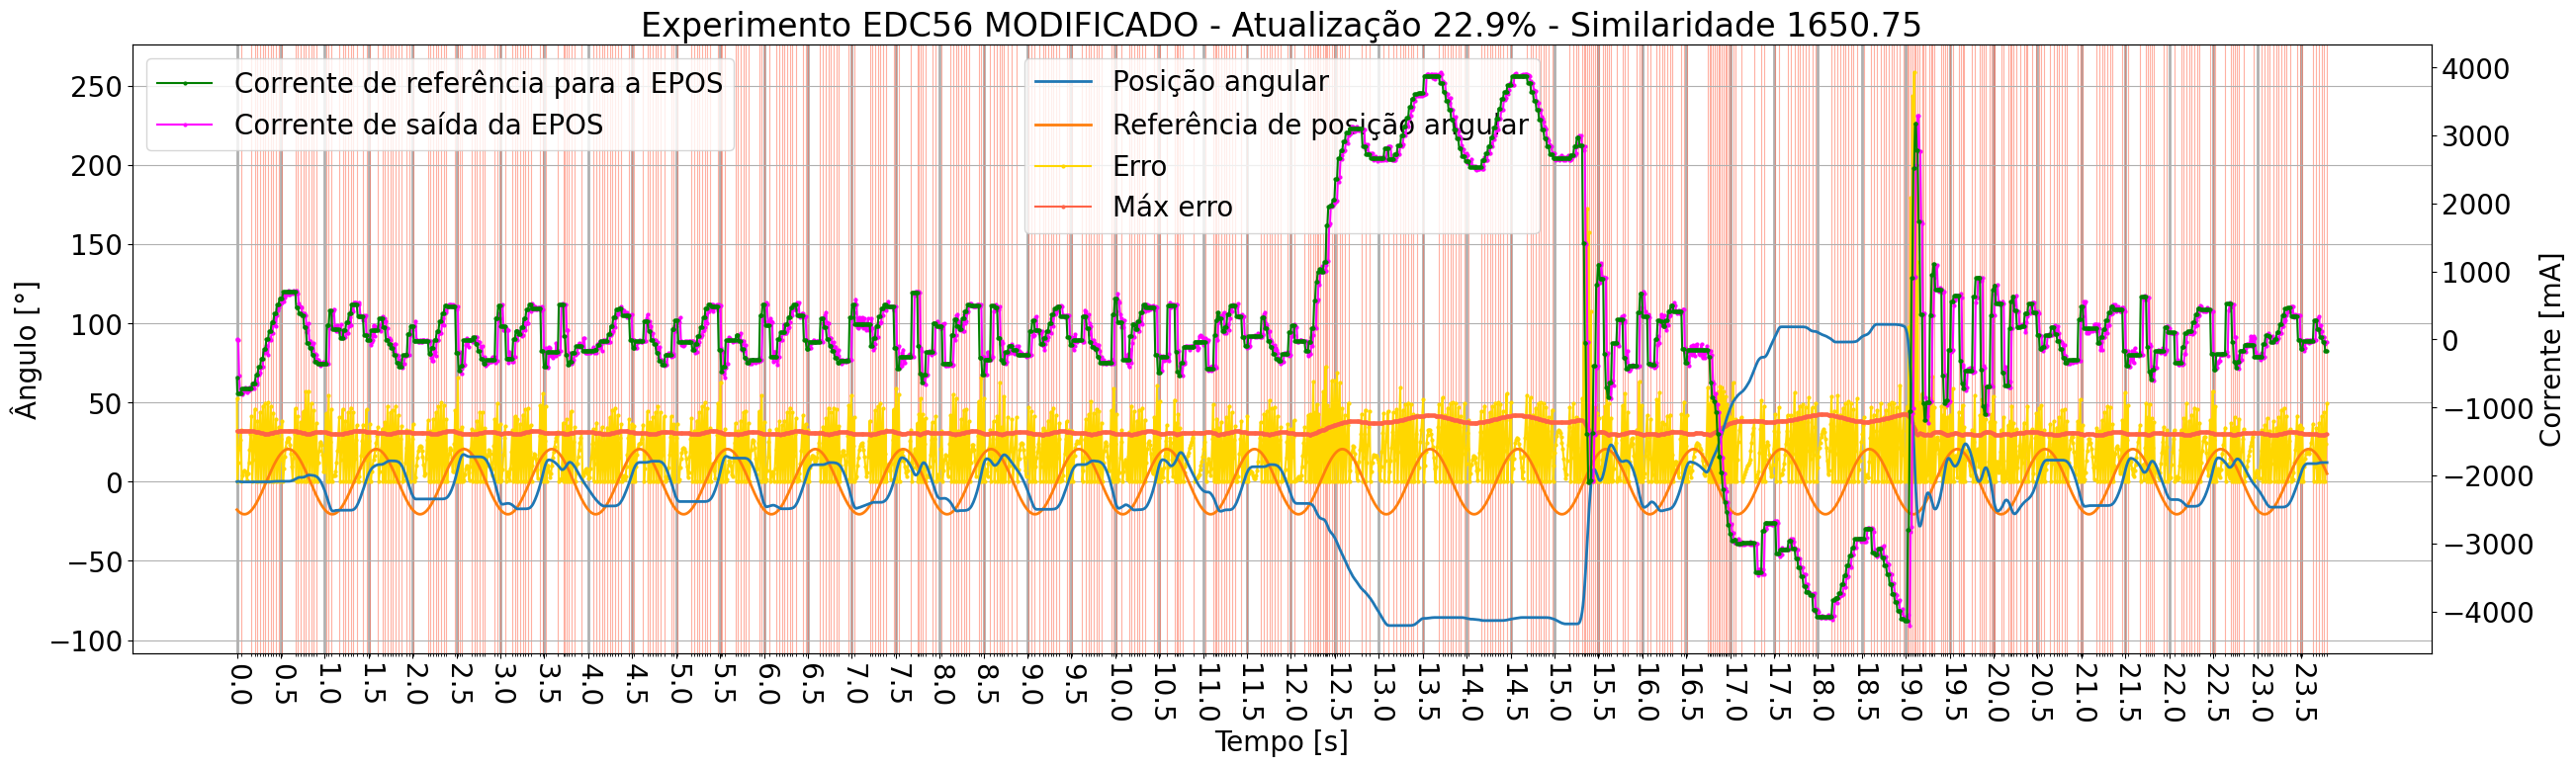

time_us  pulse_qc  setpoint_current_mA  actual_current_mA  \
0       414551         0          -556.475586                  0   
1       419080         3          -788.648315                 -1   
2       429310         3          -788.648315                 -1   
3       439461         2          -788.648315               -533   
4       449419        -1          -788.648315               -758   
...        ...       ...                  ...                ...   
2376  24169421       235           -37.315964                 31   
2377  24179463       235           -37.315964                 31   
2378  24189420       235          -164.996674                -65   
2379  24199464       235          -164.996674                -33   
2380  24210143       235          -164.996674                -33   

      epos_velocity_unfiltered_rpm  calculated_velocity_rad/s  \
0                                0                   0.000000   
1                               30                   0.594567   
2                                0                   0.000000   
3                                0                  -0.088425   
4                                0                  -0.270415   
...                            ...                        ...   
2376                             0                   0.000000   
2377                             0                   0.000000   
2378                             0                   0.000000   
2379                             0                   0.000000   
2380                             0                   0.000000   

      tracked_reference  event_max_error  event_error  
0           -343.721008        32.030987    52.338371  
1           -349.402893        32.082470     0.000000  
2           -361.189056        32.152229    11.801135  
3           -371.409790        32.206741    21.017975  
4           -379.968842        32.239491    26.580015  
...                 ...              ...          ...  
2376         193.975388        29.527147    21.485174  
2377         171.531921        29.660280    43.928631  
2378         148.604172        29.796295     0.000000  
2379         124.887276        29.936998    23.716898  
2380          99.127808        30.089825    49.476368  

[2381 rows x 9 columns]

In [15]:
file = Path('log_2024-02-22_04-17-59_dlqr-event_EDC56_modified.csv')

plotManoplaExperiment(file,
                      "Experimento EDC56 MODIFICADO - Atualização {}% - Similaridade {}",
                      ControlType.EventDLQR,
                      ReferenceType.SineWave,
                      xlabelrotation=-90)

df = pd.read_csv(file, skiprows = 12)
df